#Installs and imports


In [1]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.1 MB/s eta 0:00:00


In [2]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.3 MB/s eta 0:00:00


In [4]:
import chart_studio

In [6]:
chart_studio.tools.set_credentials_file(username='nnikolovskii', api_key='qsg9rbsgBMeOjsF6SrM9')

In [7]:
from shutil import copyfile

In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
from torch import Tensor

In [11]:
import numpy as np

In [12]:
import copy

In [13]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [14]:
import random

In [15]:
import plotly.express as px

In [16]:
import torch

In [17]:
import math

In [18]:
from torch.utils.data import Dataset

In [ ]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.9 MB/s eta 0:00:00


In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

In [ ]:
import torch_geometric.transforms as T

In [ ]:
from tqdm import tqdm

In [ ]:
import plotly.graph_objects as go

In [ ]:
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx import connected_components
import matplotlib.pyplot as plt
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Downloading datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
csv_file_path = '/content/drive/MyDrive/student_features.csv'
#Here are all of the student features
student_f = pd.read_csv(csv_file_path).drop(columns=["Unnamed: 0"])

In [ ]:
student_f.head()

In [ ]:
csv_file_path = '/content/drive/MyDrive/course_features.csv'
#All of the course features
course_f = pd.read_csv(csv_file_path).drop(columns=["Unnamed: 0"])

In [ ]:
course_f.head()

In [ ]:
csv_file_path = '/content/drive/MyDrive/subject_embeddings.csv'
#All of the subject features
subject_f = pd.read_csv(csv_file_path).drop(columns=["Unnamed: 0"])

In [ ]:
subject_f.head()

In [ ]:
csv_file_path = '/content/drive/MyDrive/triplets.csv'
#All of the triplets, heat relation and tail
triplets_df = pd.read_csv(csv_file_path)

There are 147,000 relations:
- student attended course
- professor instructed course
- course covers subject

In [ ]:
print(f"Number of relations in the dataset: {len(triplets_df)}")

In [ ]:
triplets_df.head()

#Indexing all nodes and relation

In [ ]:
from torch_geometric.data import HeteroData

With this a dictionary is created where the key is the node type. For each node type (student, professor, course and subject), we have a dictionary, where each of their keys (unique ids) is mapped to a unique index between 0 and num_nodes.

In [ ]:
def get_or_set_id_node_mapping(entity, entity_type, mapping_dict):
  if entity_type not in mapping_dict:
    mapping_dict[entity_type] = {}

  id_entity = mapping_dict[entity_type].get(entity, -1)
  if id_entity == -1:
    id_entity = len(mapping_dict[entity_type])
    mapping_dict[entity_type][entity] = id_entity

  return id_entity

Transforming all of the triplets into ids and storing the in dictionaries, seperated bu the entity type (id_to_node_mapping) and seperated by the relation type (relations_by_type)

In [ ]:
id_to_node_mapping = {}
relations_by_type = {}
for i, row in triplets_df.iterrows():
  head = row['head']
  head_type = row['head_type']
  rel = row['type']
  tail = row['tail']
  tail_type = row['tail_type']

  id_head = get_or_set_id_node_mapping(head, head_type, id_to_node_mapping)
  id_tail = get_or_set_id_node_mapping(tail, tail_type, id_to_node_mapping)



  rel_type = (head_type, rel, tail_type)

  if rel_type not in relations_by_type:
    relations_by_type[rel_type] = [[], []]

  relations_by_type[rel_type][0].append(id_head)
  relations_by_type[rel_type][1].append(id_tail)

Example for node type students:

In [ ]:
i = 0
for key in id_to_node_mapping["student"]:
  if i <10:
    print(f"Key: {key}, Value: {id_to_node_mapping['student'][key]}")
  else:
    break
  i+=1

Creating a dictionary like id_to_node_mapping, but the key is the index and the values is the unique id.

In [ ]:
node_to_id_mapping = {}
for key in id_to_node_mapping:
  node_to_id_mapping[key] = {}
  for key1 in id_to_node_mapping[key]:
    node_to_id_mapping[key][id_to_node_mapping[key][key1]] = key1


#Node features

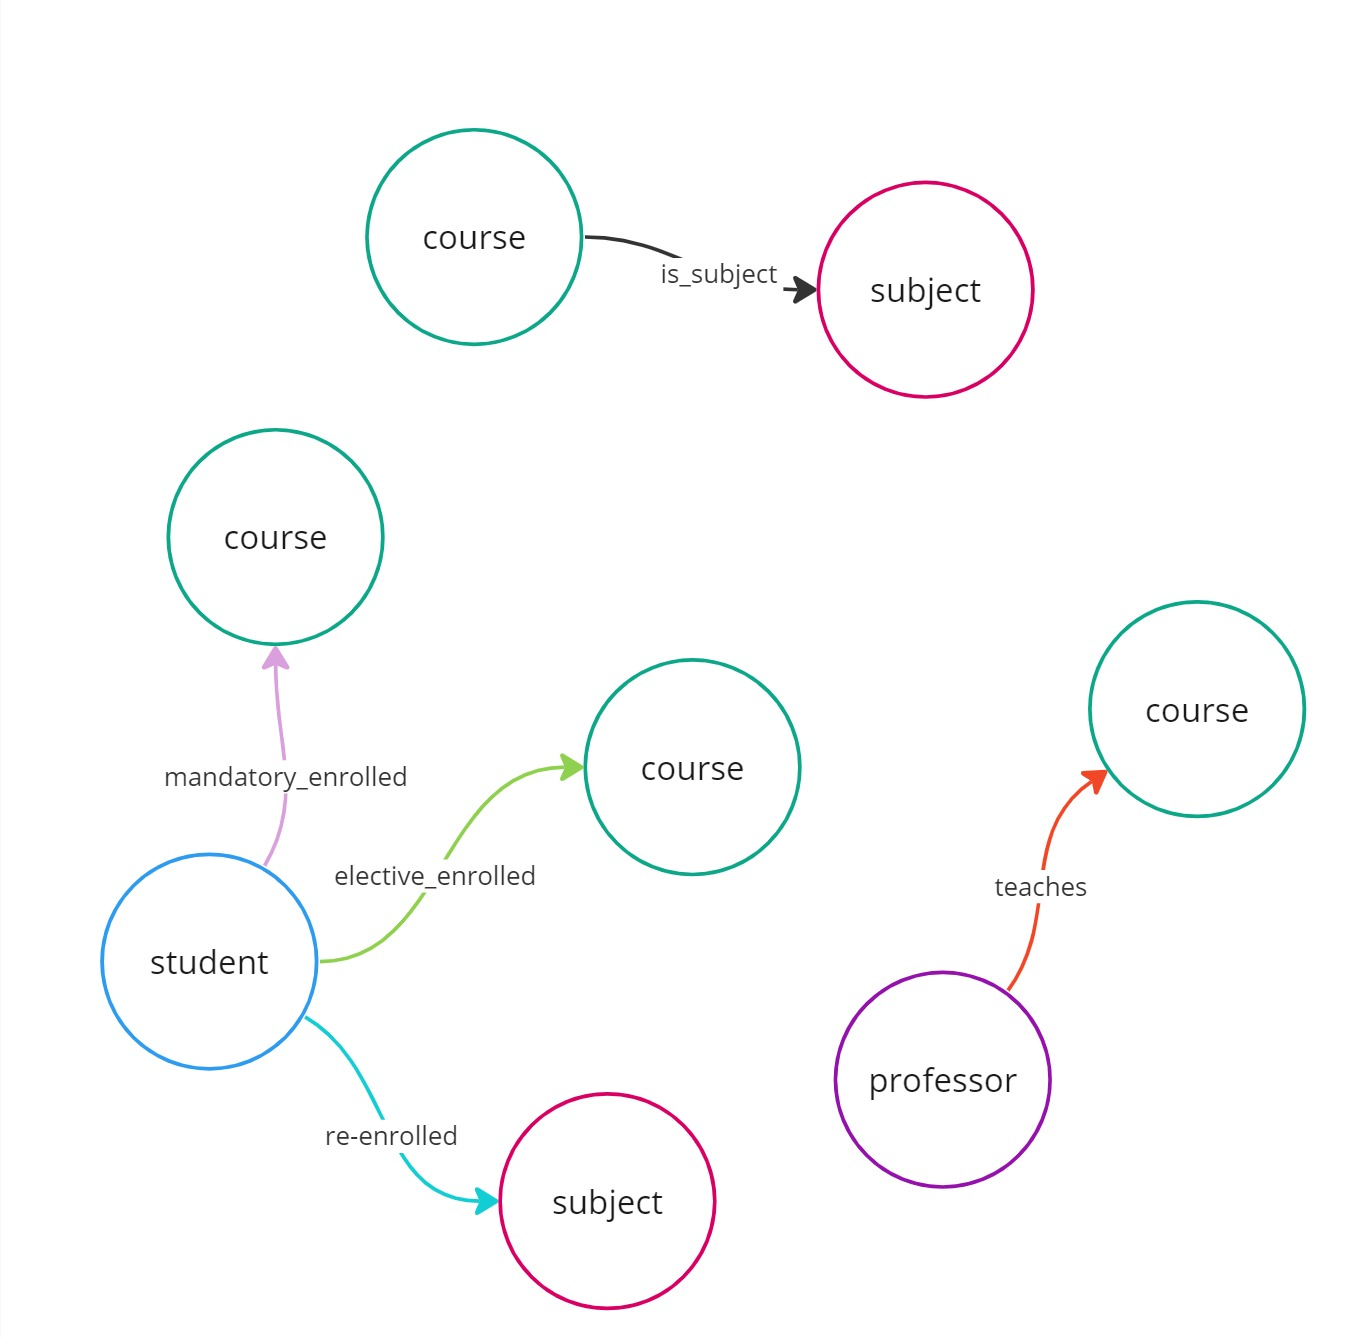

1. Features of each subject that the model will use:
- text embedding: captures subject content and weekly breakdown using language models.
- level
- semester type

2. Features of each student that the model will use:
- year of enrollment
- (optional) study program

3. Features of each course that the model will use:
- year the course is attended



##Adding features to subjects

Firstly, getting the text embedding tensors.

In [ ]:
embeddings_tensor = torch.load('/content/drive/MyDrive/embeddings_tensor.pt')

In [ ]:
embeddings_tensor.shape

Map each tensor to the unique id of the course it represents.

In [ ]:
subject_to_textemb_mapping = {}
for data, (ind, row) in zip(embeddings_tensor, subject_f.iterrows()):
  subject_to_textemb_mapping[row["ID"]] = data

Map each unique id of the course to the name of the course.

In [ ]:
code_to_name_mapping = {}

In [ ]:
for ind,row in subject_f.iterrows():
  code_to_name_mapping[row["ID"]] = row["Name"]

In [ ]:
subject_f.head(1)

Reindexing the subject df based on the id_to_node_mapping. The first element of the dataset to be the one that has index 0 in the id_to_node_mapping, and so on.

In [ ]:
subject_f = subject_f.set_index('ID').reindex(index=[code_id for code_id, _ in sorted(id_to_node_mapping["subject"].items(), key=lambda x: x[1])]).reset_index()

<font color="#FFCCCC">Test reindexing</font>

In [ ]:
subjects = list(subject_f["ID"])
for key,data in id_to_node_mapping["subject"].items():
  if key != subjects[data]:
    print("They are not correctly alligned.")
print("They are correctly alligned.")

In [ ]:
subject_f.head(2)

Use label encoder for Level and Semester Type, they also need to have indexes.

In [ ]:
from sklearn.preprocessing import LabelEncoder

level_encoder = LabelEncoder()
semester_type_encoder = LabelEncoder()

subject_f['Level'] = level_encoder.fit_transform(subject_f['Level'])
subject_f['Semester_Type'] = semester_type_encoder.fit_transform(subject_f['Semester_Type'])

subject_f.head(5)

Rearranging the text embedding tensors

In [ ]:
li = []
for ind,row in subject_f.iterrows():
  li.append(subject_to_textemb_mapping[row["ID"]])

In [ ]:
text_embeddings_tensor = torch.stack(li)

In [ ]:
text_embeddings_tensor.shape

Converting the Level and Semester_type features into tensors.

In [ ]:
import torch

level_tensor = torch.tensor(subject_f['Level'].values, dtype=torch.long).view(-1, 1)
semester_type_tensor = torch.tensor(subject_f['Semester_Type'].values, dtype=torch.long).view(-1, 1)

print("Data type of Level tensor:", level_tensor.dtype)
print("Data type of Semester_Type tensor:", semester_type_tensor.dtype)

subject_tensor = torch.cat([text_embeddings_tensor, level_tensor, semester_type_tensor], dim=1)
subject_tensor.shape

The first 384 features represent text embeddings from a Sentence Semantic Language Transformer. The last two are the Level and Semester type of the course.

In [ ]:
subject_tensor[:, :-2]

##Prerequisites for subjects

These are the subjects that are shared across all types of study programs.

In [ ]:
mandatory_subejcts= ['Алгоритми и податочни структури',
 'Бази на податоци',
 'Објектно-ориентирано програмирање',
 'Оперативни системи',
 'Професионални вештини',
 'Структурно програмирање']

Finding all the subjects that have prerequisites on them, and are not shared across all study programs. The reason this is done is becouse the majority of elective subjects have prerequsites, and the goal of the model will be to predict only the elective subjects.

In [ ]:
subjects_with_prereq = []
for ind,row in subject_f.iterrows():
  if not pd.isna(row["Prerequisites"]) and row["Name"] not in mandatory_subejcts:
    subjects_with_prereq.append(ind)

In [ ]:
len(subjects_with_prereq)/len(subject_f)*100

In [ ]:
len(subjects_with_prereq)

##Adding features course

Reindexing the courses.

In [ ]:
course_f = course_f.set_index('Course').reindex(index=[code_id for code_id, _ in sorted(id_to_node_mapping["course"].items(), key=lambda x: x[1])]).reset_index()

<font color="#FFCCCC">Test reindexing</font>

In [ ]:
courses = list(course_f["Course"])
for key,data in id_to_node_mapping["course"].items():
  if key != courses[data]:
    print("They are not correctly alligned.")
print("They are correctly alligned.")

In [ ]:
course_f.head()

Mapping each course index to its subject index.

In [ ]:
course_to_subject_map = {}

In [ ]:
for ind,row in course_f.iterrows():
  course_to_subject_map[ind] = id_to_node_mapping["subject"][row["Subject_Id"]]

In [ ]:
len(course_to_subject_map)

Encode the Year values to indexes from 0 to len(years).

In [ ]:
year_encoder = LabelEncoder()

course_f['Year'] = year_encoder.fit_transform(course_f['Year'])

course_f.head(1)

Show all the labels of the encoding.

In [ ]:
print("Year mappings:", dict(zip(year_encoder.classes_, range(len(year_encoder.classes_)))))

Convert it into a tensor.

In [ ]:
year_tensor = torch.tensor(course_f['Year'].values, dtype=torch.long).view(-1, 1)

In [ ]:
year_tensor.shape

In [ ]:
year_tensor.dtype

##Adding features to stundets

Reindexing students

In [ ]:
student_f = student_f.set_index('Id').reindex(index=[code_id for code_id, _ in sorted(id_to_node_mapping["student"].items(), key=lambda x: x[1])]).reset_index()

<font color="#FFCCCC">Test reindexing</font>

In [ ]:
courses = list(course_f["Course"])
for key,data in id_to_node_mapping["course"].items():
  if key != courses[data]:
    print("They are not correctly alligned.")
print("They are correctly alligned.")

Encode the enrollment year of each student.

In [ ]:
e_year_encoder = LabelEncoder()

student_f['Enrollment_Year'] = e_year_encoder.fit_transform(student_f['Enrollment_Year'])

Show the labels of the encoding.

In [ ]:
print("Enrollment_Year mappings:", dict(zip(e_year_encoder.classes_, range(len(e_year_encoder.classes_)))))

Convert it into a string

In [ ]:
student_tensor = torch.tensor(student_f['Enrollment_Year'].values, dtype=torch.long).view(-1, 1)

#Removing courses

##Hetero Data (with course)

The final goal for our model is to make recommendations for elective subjects. One way to do this is by using the inference power of Graph Nueral Networks (GNNs). The reason GNN are used for this data is because of the feature engineering that it can do. Instead of defining our own features, by using GNNs these features are created based on the neigbours of each node, and the structure of the whole graph.


Recommendations heavily rely on a student's past attended subjects and the professors associated with those subjects. To tackle this challenge, we construct a heterogeneous graph, utilizing it to perform link prediction. The model will create an embedding for each node, and the way these embeddins are going to be formed is by the neigbourhood of each node, so in this way the structure of the graph is taken into consideration. This strategy enables us to effectively analyze the connections between courses, professors, and student enrollment data.

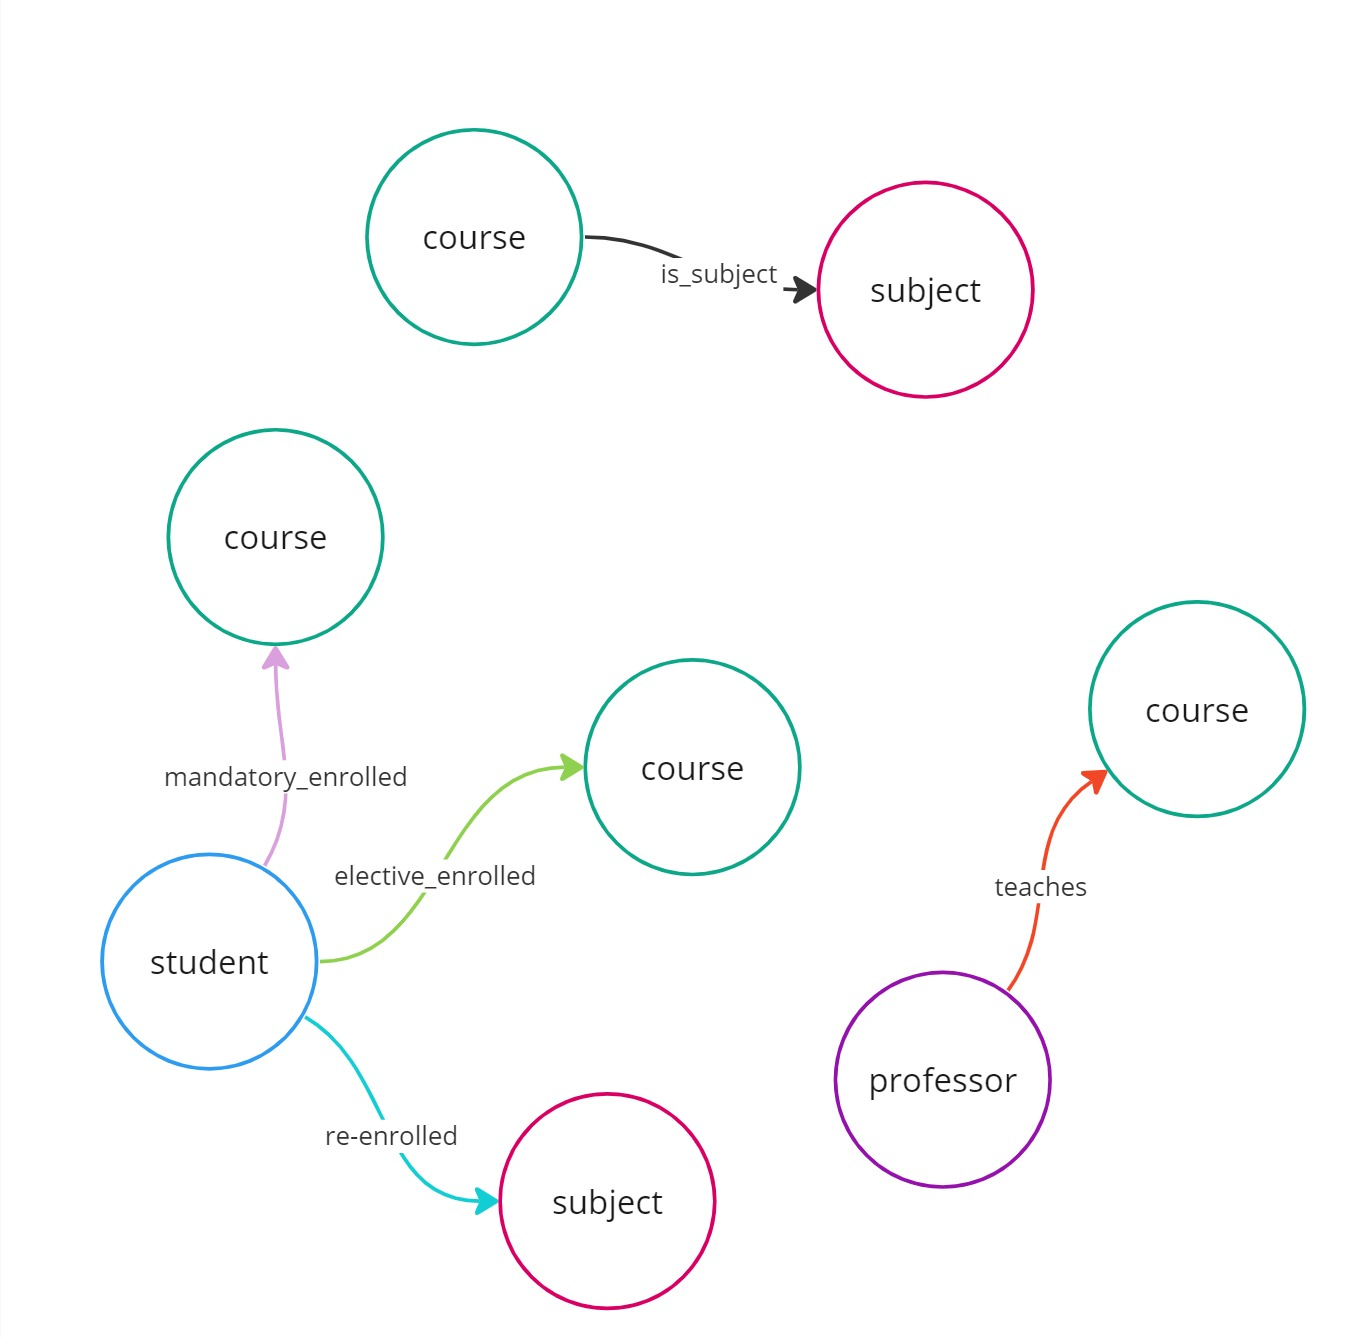

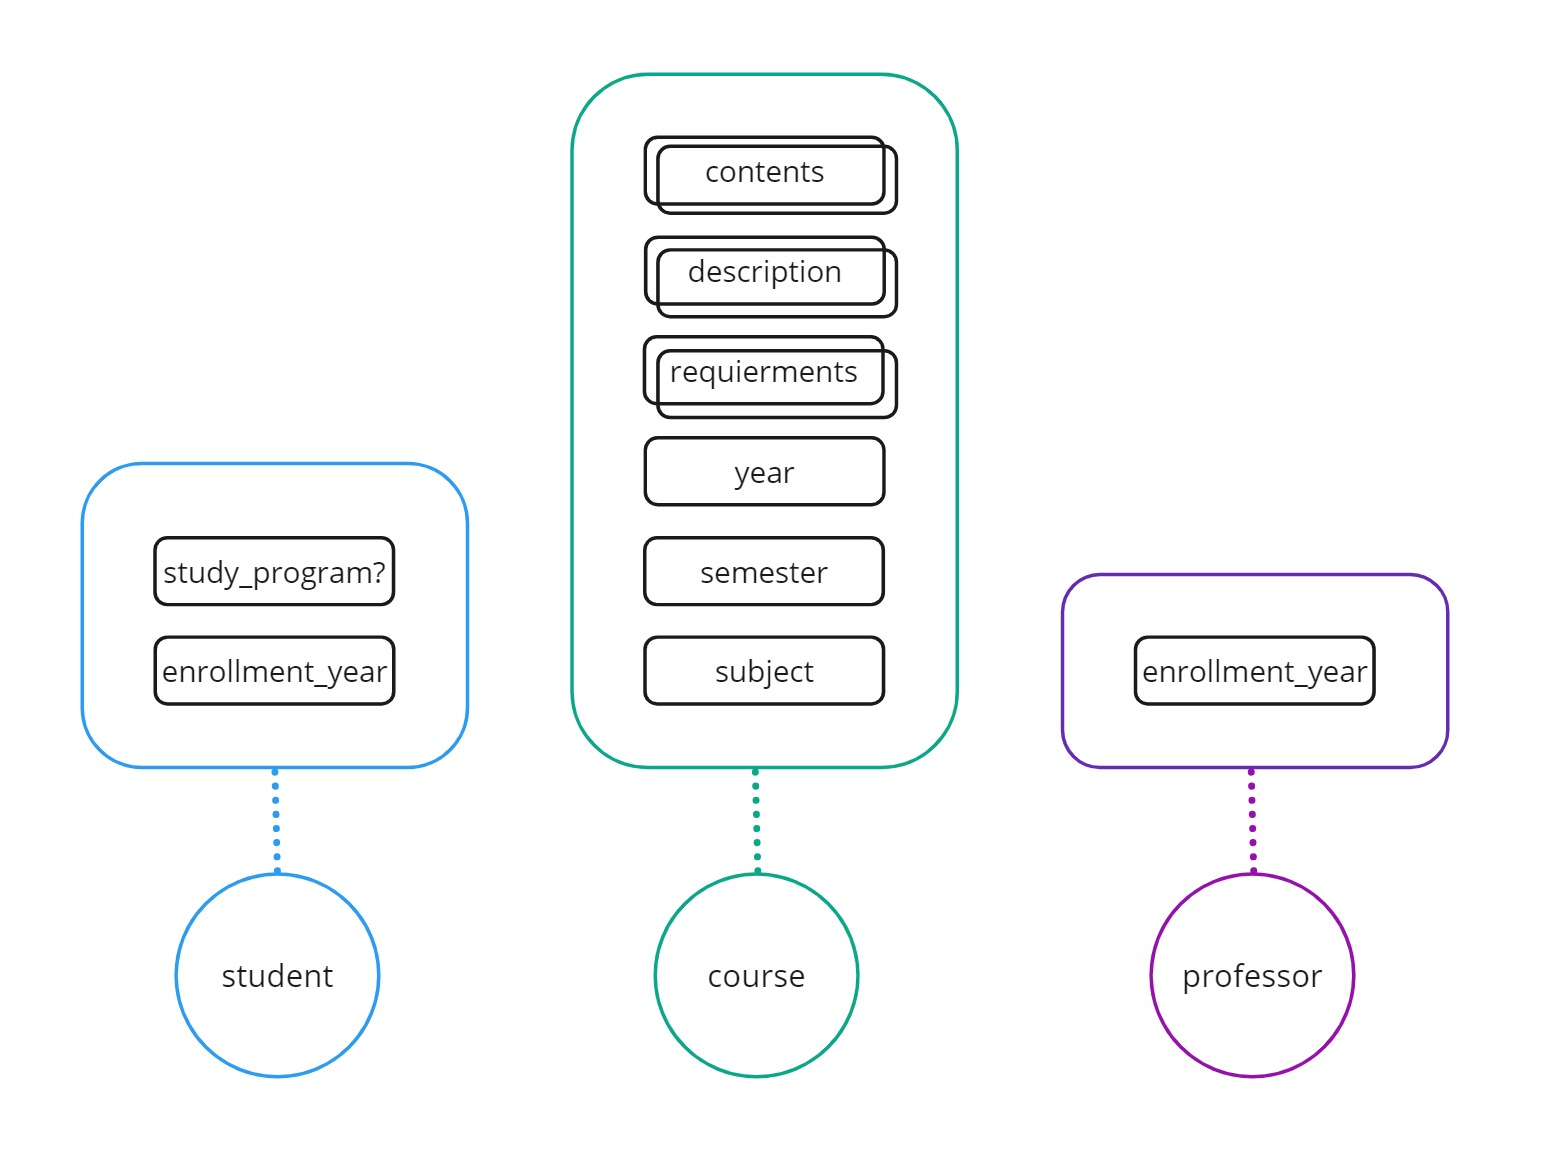

The initial plan was to add course and subject nodes as seperate entities. However, the problem with this is that when we perform link preiction on elective courses, some of them have very few students. This later will cause a problem when we do edge splits, there will be too few samples for each course. That is why we aggregate all courses to its subject type and we remove the course nodes. Also, if a professor has instructed at least one course on a specific subject, he will be connected to that subject.

In [ ]:
data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

for rel_type in relations_by_type.keys():
  data[rel_type].edge_index = torch.tensor(relations_by_type[rel_type])

data = T.ToUndirected()(data)
data["subject"].x = subject_tensor
data["course"].x = year_tensor
data["student"].x = student_tensor

In [ ]:
data

##Removing subjects

In edge_index all of the edges are stored that have the relation (students, attended, course)

In [ ]:
edge_index = data['student', 'attended', 'course'].edge_index.t()

In [ ]:
student_subject = []
for i in range(len(edge_index)):
  course = edge_index[i][1].item()
  #map each course index to its relevant subject index
  subject = course_to_subject_map[course]
  student_subject.append([edge_index[i][0].item(), subject])

In [ ]:
student_subject[0:10]

Do the same thing for (professors, instructed, course)

In [ ]:
edge_index = data['professor', 'instructed', 'course'].edge_index.t()

In [ ]:
professor_subject = []
for i in range(len(edge_index)):
  course = edge_index[i][1].item()
  subject = course_to_subject_map[course]
  professor_subject.append([edge_index[i][0].item(), subject])

In [ ]:
professor_subject[0:10]

Convert them into a tensor.

In [ ]:
student_subject = torch.tensor(student_subject).t()
professor_subject = torch.tensor(professor_subject).t()

In [ ]:
print(student_subject.shape)
print(professor_subject.shape)

##Hetero Data (without course)

Create a hetero data instace now without courses, only with subjects.

In [ ]:
data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

data[("student", "attended", "subject")].edge_index = student_subject
data[("professor", "instructed", "subject")].edge_index = professor_subject


data = T.ToUndirected()(data)
data["subject"].x = subject_tensor
data["student"].x = student_tensor

In [ ]:
data

#Number of students in subjects

We want to see for each subject how many students have attended it over the years.

In [ ]:
edge_index = data['student', 'attended', 'subject'].edge_index.t()

In [ ]:
edge_index = data['student', 'attended', 'subject'].edge_index.t()
subjects = {}
for i in range(len(edge_index)):
  item = edge_index[i][1].item()

  if item not in subjects:
    subjects[item] = []
  subjects[item].append(edge_index[i][0].item())

li = [[name1, num_students1]...[name_n, num_students_n]]

In [ ]:
li = [[code_to_name_mapping[node_to_id_mapping["subject"][key]], len(subjects[key]),  len(subjects[key])/len(edge_index)*100] for key in subjects]

Sort the list by the number of students.


In [ ]:
li = sorted(li, key=lambda x: x[1], reverse=True)

In [ ]:
li[0:10]

Plot the all the subjects that have more than 1000 students.

In [ ]:
values = [item[1] for item in li if item[1]>1000]
labels = [li[i][0] for i in range(0, len(values))]

fig = px.bar(li, x=labels, y=values)
fig.update_layout(xaxis=dict(title='', tickmode='array', tickvals=[]))

In [ ]:
# chart_url = py.plot(fig, filename='lol1', auto_open=False)

# # Print the URL where the plot is hosted
# print(f'Plot uploaded to: {chart_url}')

Show all of the subjects.

In [ ]:
li = sorted(li, key=lambda x: x[1], reverse=True)
labels = [item[0] for item in li]
values = [item[1] for item in li]

fig = px.bar(li, x=labels, y=values)
fig.update_layout(xaxis=dict(title='', tickmode='array', tickvals=[]))

In [ ]:
# chart_url = py.plot(fig, filename='lol2', auto_open=False)

# # Print the URL where the plot is hosted
# print(f'Plot uploaded to: {chart_url}')

Show only the subjects that have prerequisites and are not shared across study programs.

In [ ]:
li = [[code_to_name_mapping[node_to_id_mapping["subject"][key]], len(subjects[key]),  len(subjects[key])/len(edge_index)*100] for key in subjects if key in subjects_with_prereq]

In [ ]:
li = sorted(li, key=lambda x: x[1], reverse=True)
labels = [item[0] for item in li]
values = [item[1] for item in li]

fig = px.bar(li, x=labels, y=values)
fig.update_layout(xaxis=dict(title='', tickmode='array', tickvals=[]))

In [ ]:
chart_url = py.plot(fig, filename='lol3', auto_open=False)

# Print the URL where the plot is hosted
print(f'Plot uploaded to: {chart_url}')

These subjects cover 50% of the relations. These subjects also are 80% of all of the subjects. That meand the other 20% of subjects have the other 50% of the relations which is a big number of relations for that much smaller number of subjects.

In [ ]:
sum([item[1] for item in li])/len(edge_index)*100

In [ ]:
len(li)/len(subject_f)*100

Removing items with very few number of stundents

In [ ]:
import chart_studio
import chart_studio.plotly as py

In [ ]:
li = sorted(li, key=lambda x: x[1])
labels = [item[0] for item in li[:40]]
values = [item[1] for item in li[:40]]
fig = px.bar(li, x=labels, y=values)
fig.update_layout(xaxis=dict(title='', tickmode='array', tickvals=[]))

In [ ]:
# chart_url = py.plot(fig, filename='lol', auto_open=False)

# # Print the URL where the plot is hosted
# print(f'Plot uploaded to: {chart_url}')

Get the subjects with 8 or fewer number of students accumulated from 2018 till now.

In [ ]:
li = [[key, len(subjects[key]),  len(subjects[key])/len(edge_index)*100] for key in subjects if key in subjects_with_prereq]
li = sorted(li, key=lambda x: x[1])
values = [item[1] for item in li if item[1] <= 8]
irrelevant_subjects = [item[0] for item in li[:len(values)]]
irrelevant_subjects

In [ ]:
[code_to_name_mapping[node_to_id_mapping["subject"][elem]] for elem in irrelevant_subjects]

We will split the edges into subjects with prerequisites and subjects with no prerequsites. The first ones will be called elective and the second ones mandatory. The mandatory student-subject relations will be only used for message passing. On the other hand, the elective student-subject relations will be used for link prediction. The goal of this model is to primary predict these types of subjects, the ones that can be elected by the choice of the student.

In [ ]:
edge_index = data['student', 'attended', 'subject'].edge_index.t()
target_edge_index = []
train_edge_index = []
c_irrelevant = 0

for i in range(len(edge_index)):
  item = edge_index[i][1].item()

  if item in irrelevant_subjects:
    c_irrelevant+=1
  else:
    if item not in subjects_with_prereq:
      train_edge_index.append([edge_index[i][0].item(), edge_index[i][1].item()])
    else:
      target_edge_index.append([edge_index[i][0].item(), edge_index[i][1].item()])

<font color="#FFCCCC">Test if the split is correct</font>

In [ ]:
c_irrelevant

In [ ]:
len(target_edge_index) + len(train_edge_index) == len(edge_index) - c_irrelevant

In [ ]:
len(target_edge_index)/len(edge_index)*100

In [ ]:
len(train_edge_index)/len(edge_index)*100

Converting them to tensors

In [ ]:
target_edge_index = torch.tensor(target_edge_index).t()
train_edge_index = torch.tensor(train_edge_index).t()

#Hetero Data (only elective subjects)

In [ ]:
data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

data[("professor", "instructed", "subject")].edge_index = professor_subject
data[('student', 'elective_attended', 'subject')].edge_index= target_edge_index
data[('student', 'mandatory_attended', 'subject')].edge_index = train_edge_index
data = T.ToUndirected()(data)
data["subject"].x = subject_tensor
data["student"].x = student_tensor

In [ ]:
data

#Edge split

For the graph embeddings the model will use GAT layers. These layers incorporate message passing and aggregation.

We want to see how many GCN layers are optimal. If its one layer than each node embedding will be formed by the node embeddings from the one-hop neighbours. If there are two, from the 2-hop neighbours and so on.

Additionaly, each course has its own features which are its text embeddings (from some Sentence Transformer), level of the subject (numerical), prerequisites (categorical) and year.

Each students and professor has only Enrollment Year (numerical). That is the reason why we will use graph embeddings to get new features from the different connections in the graph

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data

##Message, supervion, val and test edges

Training will be performed using link prediction only on the edge type elective_attended. All other edge types will be used for message passing.

Furthermore, we will split the elective_attended edges into message passing, supervision, test and train edges.

<font color="lightgreen">Training
- features: message
- target: supervision
</font>

<font color="lightgreen">Validation
- features: message + supervision
- target: validation
</font>

<font color="lightgreen">Testing
- features: message + supervision
- target: testing
</font>


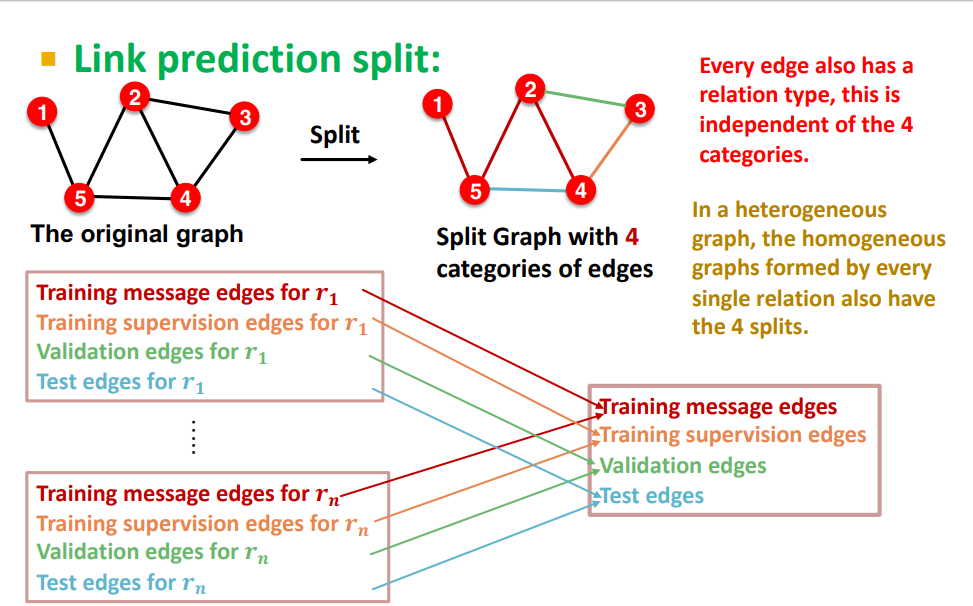

subjects (dict) - key: subject index, value list of students that attended that subject

In [ ]:
edge_index = data['student', 'elective_attended', 'subject'].edge_index.t()
subjects = {}
for i in range(len(edge_index)):
  item = edge_index[i][1].item()
  if item not in subjects:
    subjects[item] = []
  subjects[item].append(edge_index[i][0].item())

In [ ]:
li = [[code_to_name_mapping[node_to_id_mapping["subject"][key]], len(subjects[key]),  len(subjects[key])/len(edge_index)*100] for key in subjects]

In [ ]:
li = sorted(li, key=lambda x: x[1], reverse=True)
values = [item[1] for item in li if item[1]>1000]
labels = [li[i][0] for i in range(0, len(values))]
fig = px.bar(li, x=labels, y=values)
fig.update_layout(xaxis=dict(title='', tickmode='array', tickvals=[]))

In [ ]:
def random_split(li, ratios):
  #randomize the list
  r_li = {}
  labels = ["validation", "test", "supervision", "message"]
  random.shuffle(li)
  #define num of elements
  splits = [int(len(li)*elem) for elem in ratios]
  for i,s in enumerate(splits):
    if i == len(splits)-1:
      r_li[labels[i]] = li
    else:
      r_li[labels[i]] = (li[:s])
      li = li[s:]

  return r_li

In [ ]:
splits = {}
for key in subjects:
  li = subjects[key]
  splits[key] = random_split(li, [0.1, 0.1, 0.4, 0.4])

<font color="#FFCCCC">Testing the split</font>

In [ ]:
for key, data in splits.items():
    split_name = code_to_name_mapping[node_to_id_mapping['subject'][key]]
    print(f"{split_name}: {len(data['validation'])} {len(data['test'])} {len(data['supervision'])} {len(data['message'])}")

In [ ]:
li = [[code_to_name_mapping[node_to_id_mapping["subject"][key]], len(data['validation']), len(data['test']), len(data['supervision']), len(data['message']),len(subjects[key])] for key, data in splits.items()]

In [ ]:
li = sorted(li, key=lambda x: x[1])

<font color="#FFCCCC">Testing to see if all elements are taken for the splitting</font>

In [ ]:
li1 = [elem[1]+elem[2]+elem[3]+elem[4]==elem[5] for elem in li]
set(li1)

For each subject save the existing connections in a set.

In [ ]:
existing_connections = {}
for key,data in splits.items():
  val = data['validation']
  test = data['test']
  supervision = data['supervision']
  message = data['message']
  existing_connections[key] = set(val+test+supervision+message)

Using the splits for creating the 4 types of edges that we need for our training: message, supervision, test and val.

In [ ]:
message = []
supervision = []
test = []
val = []
for key,data in splits.items():
  val_s = data['validation']
  test_s = data['test']
  supervision_s = data['supervision']
  message_s = data['message']

  message.extend([[el, key] for el in message_s])
  supervision.extend([[el, key] for el in supervision_s])
  test.extend([[el, key] for el in test_s])
  val.extend([[el, key] for el in val_s])

##Negative sampling

Negative sampling is crucial for our link prediction task. We do not want to train out model only on positive samples. The way these negative samples are formed is bu corrcupting the tail of the relation, and creating a link that does not exist in the real graph. When creating negative sampling they must be different from the links that already exist in the graph.

In [ ]:
def add_unique_elements(existing_elements, n, range_start, range_end):
  r"""existing_elements (set): Set of all existing elements from which we do not want to sample
      n (int): The ratio of sampled negative edges to the number of positive edges
  """
  all_elements = set(range(range_start, range_end))
  rest = list(all_elements- existing_elements)
  n = min(n, len(rest))
  rand = random.sample(rest, n)
  return rand

In [ ]:
def create_neg_samples(n, edge_type, splits, existing_connections):
  r"""n (int): The ratio of sampled negative edges to the number of positive edges
  """
  edges = []
  labels = []

  for key,data in tqdm(splits.items()):
    pos = data[edge_type]

    neg = add_unique_elements(existing_connections[key], n*len(pos),0, len(student_f))

    edges.extend([[el, key] for el in pos+neg])
    labels.extend([1 for el in pos])
    labels.extend([0 for el in neg])

  return torch.tensor(edges).t().contiguous(), torch.tensor(labels).t().contiguous().float()

In [ ]:
train_index_label, train_label = create_neg_samples(2, "supervision", splits, existing_connections)

In [ ]:
val_index_label, val_label = create_neg_samples(2, "validation", splits, existing_connections)

In [ ]:
test_index_label, test_label = create_neg_samples(2, "test", splits, existing_connections)

Creating a list of different negative samples for testing

In [ ]:
test_neg_li = []
for i in range(5):
  edges, labels = create_neg_samples(2+i, "test", splits, existing_connections)
  test_neg_li.append((edges, labels))

In [ ]:
test_neg_li[0][0].shape

In [ ]:
test_neg_li[1][0].shape

In [ ]:
test_neg_li[2][0].shape

Converting them into tensors

In [ ]:
supervision = torch.tensor(supervision).t().contiguous()
message = torch.tensor(message).t().contiguous()
val = torch.tensor(val).t().contiguous()
test = torch.tensor(test).t().contiguous()

In [ ]:
print(message.shape)
print(supervision.shape)
print(test.shape)
print(val.shape)

In [ ]:
print(train_index_label.shape)
print(train_label.shape)
print(test_index_label.shape)
print(test_label.shape)
print(val_index_label.shape)
print(val_label.shape)

<font color="#FFCCCC">Testing splits if they overlap</font>

In [ ]:
def edge_index_to_set(edge_index):
  edge_index = edge_index.t()
  s = set()
  for el in edge_index:
    s.add((el[0].item(), el[1].item))
  return s

In [ ]:
s_train = edge_index_to_set(train_index_label)
s_test = edge_index_to_set(test_index_label)
s_val = edge_index_to_set(val_index_label)

In [ ]:
train_test_overlap = s_train & s_test
train_val_overlap = s_train & s_val
test_val_overlap = s_test & s_val

In [ ]:
print(len(train_test_overlap) == 0)
print(len(train_val_overlap) == 0)
print(len(test_val_overlap) == 0)

In [ ]:
s_message = edge_index_to_set(message)
s_val = edge_index_to_set(val)
s_supervision = edge_index_to_set(supervision)
s_test = edge_index_to_set(test)

In [ ]:
overlap_results = {
    "message_val_overlap": len(s_message & s_val) == 0,
    "message_supervision_overlap": len(s_message & s_supervision) == 0,
    "message_test_overlap": len(s_message & s_test) == 0,
    "val_supervision_overlap": len(s_val & s_supervision) == 0,
    "val_test_overlap": len(s_val & s_test) == 0,
    "supervision_test_overlap": len(s_supervision & s_test) == 0
}

for key, value in overlap_results.items():
    print(f"Overlap between {key.split('_')[0]} and {key.split('_')[1]}:", value)

##Train, val, test hetero data

For training edge_index are only the message passing edges.

In [ ]:
train_data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    train_data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

train_data[("professor", "instructed", "subject")].edge_index = professor_subject.contiguous()
#Only message passing edges
train_data[('student', 'elective_attended', 'subject')].edge_index= message.contiguous()
train_data[('student', 'mandatory_attended', 'subject')].edge_index = train_edge_index.contiguous()
train_data = T.ToUndirected()(train_data)
train_data["subject"].x = subject_tensor.contiguous()
train_data["student"].x = student_tensor.contiguous()

For validation and testing edge_index are both message and supervision edges.

In [ ]:
val_data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    val_data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

val_data[("professor", "instructed", "subject")].edge_index = professor_subject.contiguous()
#Use both message and supervision for training
val_data[('student', 'elective_attended', 'subject')].edge_index= torch.cat((message, supervision), dim=1).contiguous()
val_data[('student', 'mandatory_attended', 'subject')].edge_index = train_edge_index.contiguous()
val_data = T.ToUndirected()(val_data)
val_data["subject"].x = subject_tensor.contiguous()
val_data["student"].x = student_tensor.contiguous()

In [ ]:
test_data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    test_data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

test_data[("professor", "instructed", "subject")].edge_index = professor_subject.contiguous()
#Use both message and supervision for training
test_data[('student', 'elective_attended', 'subject')].edge_index= torch.cat((message, supervision), dim=1).contiguous()
test_data[('student', 'mandatory_attended', 'subject')].edge_index = train_edge_index.contiguous()
test_data = T.ToUndirected()(test_data)
test_data["subject"].x = subject_tensor.contiguous()
test_data["student"].x = student_tensor.contiguous()

In [ ]:
train_data

In [ ]:
val_data

In [ ]:
test_data

In [ ]:
def print_edge_labels(edge_label):
  tensor_data = edge_label
  numpy_array = tensor_data.numpy()
  unique_values, counts = np.unique(numpy_array, return_counts=True)

  for value, count in zip(unique_values, counts):
      print(f"{value}: {count}")

In [ ]:
def print_subjects(edge_index):
  s = set()
  labels_d = {}
  courses = edge_index["student", "elective_attended", "subject"].edge_label_index[1]
  labels = edge_index["student", "elective_attended", "subject"].edge_label
  for i in range(len(courses)):
          item = courses[i].item()
          if item not in labels_d:
            labels_d[item] = []
          labels_d[item].append(labels[i])
  for key in labels_d:
    tensor_list = list(labels_d[key])
    num_zeroes = sum(1 for item in tensor_list if item == 0)
    num_ones = sum(1 for item in tensor_list if item == 1)

    s.add(code_to_name_mapping[node_to_id_mapping["subject"][key]])
  print(s)

#Dataset and data loader

In [ ]:
def create_batch(edge_label_index, edge_label, batch_size, n):
  r"""n: The ratio of sampled negative edges to the number of positive edges
  """
  edge_label_index = edge_label_index.t()
  X = np.array(torch.cat([edge_label_index, edge_label.unsqueeze(1)], dim=1))
  mapping = {}
  mapping[0] = []
  mapping[1] = []
  for i in range(len(X)):
    student = X[i][0].item()
    subject = X[i][1].item()
    label = X[i][2].item()
    if label == 0:
      mapping[0].append((student, subject, 0))
    else:
      mapping[1].append((student, subject, 1))

  n = math.ceil(batch_size * 1 / (n+1))
  m = math.floor(batch_size * n / (n+1))

  random.shuffle(mapping[1])
  random.shuffle(mapping[0])

  X=[]

  while mapping[1]:
    n = min(n, len(mapping[1]))
    m = min(m, len(mapping[0]))
    pos =  mapping[1][:n]
    neg = mapping[0][:m]

    X.append(pos+neg)
    mapping[1] = mapping[1][n:]
    mapping[0] = mapping[0][m:]

  return X


In [ ]:
X_train = create_batch(train_index_label, train_label, 128, 2)
X_val = create_batch(val_index_label, test_label, 128, 2)
X_test = create_batch(test_index_label, val_label, 128, 2)
X_test_li = [create_batch(elem[0], elem[1], 128, 2+i) for i,elem in enumerate(test_neg_li)]

In [ ]:
test_neg_li[0][0].shape

In [ ]:
test_neg_li[1][0].shape

<font color="#FFCCCC">Test if the batches are disjoint</font>

In [ ]:
def disjointness_and_similarity(list_of_lists):
    total_similar_elements = 0
    for i in range(len(list_of_lists)):
        for j in range(i + 1, len(list_of_lists)):
            intersection_size = len(set(list_of_lists[i]).intersection(set(list_of_lists[j])))
            total_similar_elements += intersection_size
            if intersection_size > 0:
                return False, total_similar_elements
    return True, total_similar_elements

In [ ]:
disjointness_and_similarity(X_train)

In [ ]:
disjointness_and_similarity(X_val)

In [ ]:
disjointness_and_similarity(X_test)

Creating a custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, prot_data):
        self.X = X
        self.prot_data = prot_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        tmp = self.X[idx]
        edge = [[elem[0], elem[1]] for elem in tmp]
        label =  [elem[2] for elem in tmp]
        edge = torch.tensor(edge).t()
        label = torch.tensor(label)
        data= copy.copy(self.prot_data)
        data["student", "elective_attended", "subject"].edge_label_index = edge.contiguous().int()
        data["student", "elective_attended", "subject"].edge_label = label.contiguous().float()
        return data

In [ ]:
train_loader = CustomDataset(X_train, train_data)
test_loader = CustomDataset(X_test, test_data)
val_loader = CustomDataset(X_val, val_data)
test_loader_li = [CustomDataset(elem, test_data) for elem in X_test_li]

In [ ]:
train_loader[0]

In [ ]:
val_loader[1]

#Models

In [ ]:
class SubjectEmbedder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SubjectEmbedder, self).__init__()
        self.level_embedding = nn.Embedding(10, hidden_size)
        self.semester_embedding = nn.Embedding(10, hidden_size)
        self.linear_l = nn.Linear(hidden_size, hidden_size)
        self.linear_s = nn.Linear(hidden_size, hidden_size)
        self.linear_t = nn.Linear(384, hidden_size)

        self.linear_final = nn.Linear(3*hidden_size, output_size)

    def forward(self, data):
        semester_input = data[:, -1]
        level_input = data[:, -2]
        text_input = data[:, :-2]
        semester_input = semester_input.long()
        level_input = level_input.long()

        level_input = self.level_embedding(level_input)
        semester_input = self.semester_embedding(semester_input)

        input_s = self.linear_s(semester_input)
        input_l = self.linear_l(level_input)
        input_t = self.linear_t(text_input)
        concatenated_output = torch.cat([input_s, input_l, input_t], dim=1)

        final_output = F.relu(self.linear_final(concatenated_output))

        return final_output


In [ ]:
class CourseEmbedder(nn.Module):
    def __init__(self, hidden_size,output_size):
        super(CourseEmbedder, self).__init__()
        self.year_embedding = nn.Embedding(10, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, data):
        year_input = self.year_embedding(data)
        input_y = self.linear(year_input).squeeze(dim=1)
        return F.relu(input_y)


In [ ]:
class StudentEmbedder(nn.Module):
    def __init__(self, hidden_size,output_size):
        super(StudentEmbedder, self).__init__()
        self.e_year_embedding = nn.Embedding(20, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)


    def forward(self, data):
        e_year_input = self.e_year_embedding(data)
        input_e_y = self.linear(e_year_input).squeeze(dim=1)

        return F.relu(input_e_y)


In [ ]:
data= HeteroData()

for entity_type in id_to_node_mapping.keys():
  if entity_type == "course":
    pass
  else:
    data[entity_type].node_id = torch.arange(len(id_to_node_mapping[entity_type]))

data[("professor", "instructed", "subject")].edge_index = professor_subject
data[('student', 'elective_attended', 'subject')].edge_index= target_edge_index
data[('student', 'mandatory_attended', 'subject')].edge_index = train_edge_index
data = T.ToUndirected()(data)
data["subject"].x = subject_tensor
data["student"].x = student_tensor

In [ ]:
target_edge_type = ('student', 'elective_attended', 'subject')

In [ ]:
data.metadata()

(['subject', 'student', 'professor'],
 [('professor', 'instructed', 'subject'),
  ('student', 'elective_attended', 'subject'),
  ('student', 'mandatory_attended', 'subject'),
  ('subject', 'rev_instructed', 'professor'),
  ('subject', 'rev_elective_attended', 'student'),
  ('subject', 'rev_mandatory_attended', 'student')])

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_student: Tensor, x_subject: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_student = x_student[edge_label_index[0]]
        edge_feat_subject = x_subject[edge_label_index[1]]
        return (edge_feat_student * edge_feat_subject).sum(dim=-1)

class Model(torch.nn.Module):
   def __init__(self, hidden_channels):
        super().__init__()
        self.embeddings_layers = {}
        self.student_lin = torch.nn.Linear(1, hidden_channels)
        for entity_type in id_to_node_mapping:
          if entity_type != "course":
            self.embeddings_layers[entity_type] = torch.nn.Embedding(data[entity_type].num_nodes, hidden_channels).to(device)

        self.gnn = GNN(hidden_channels)
        self.subject_encoder = SubjectEmbedder(hidden_channels, hidden_channels)
        # self.course_encoder = CourseEmbedder(hidden_channels, hidden_channels)
        self.student_encoder = StudentEmbedder(hidden_channels, hidden_channels)

        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
   def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "student":self.student_encoder(data["student"].x) +self.embeddings_layers["student"](data["student"].node_id),
          # "course": self.course_encoder(data["course"].x) +self.embeddings_layers["course"](data["course"].node_id),
          "professor": self.embeddings_layers["professor"](data["professor"].node_id),
          "subject": self.subject_encoder(data["subject"].x) + self.embeddings_layers["subject"](data["subject"].node_id)
        }


        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["student"],
            x_dict["subject"],
            data[target_edge_type].edge_label_index,
        )
        return pred

In [ ]:
device

'cuda'

##Decoder

In [ ]:
data

HeteroData(
  subject={
    node_id=[153],
    x=[153, 386],
  },
  student={
    node_id=[4544],
    x=[4544, 1],
  },
  professor={ node_id=[95] },
  (professor, instructed, subject)={ edge_index=[2, 3050] },
  (student, elective_attended, subject)={ edge_index=[2, 72389] },
  (student, mandatory_attended, subject)={ edge_index=[2, 71169] },
  (subject, rev_instructed, professor)={ edge_index=[2, 3050] },
  (subject, rev_elective_attended, student)={ edge_index=[2, 72389] },
  (subject, rev_mandatory_attended, student)={ edge_index=[2, 71169] }
)

In [ ]:
num_stundent_nodes = len(data["student"].node_id)
num_stundent_nodes

4544

In [ ]:
num_subject_nodes = len(data["subject"].node_id)
num_subject_nodes

153

In [ ]:
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE

decoder = TransE(
    num_nodes=num_stundent_nodes+num_subject_nodes,
    num_relations= 1,
    hidden_channels=50,
).to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)

In [ ]:
decoder

TransE(4697, num_relations=1, hidden_channels=50)

#Training the model

In [ ]:
from tabulate import tabulate
from sklearn.metrics import roc_auc_score

def print_metrics(preds_prob, ground_truths):
  r"""For each subject calculates roc accuracy.
  """

  table_data = []
  headers = ["Subject", "Roc auc", "#pos", "#neg"]

  for key in preds_prob:
      unique_classes = len(set(ground_truths[key])) > 1
      if unique_classes:
          subject_name = code_to_name_mapping[node_to_id_mapping["subject"][key]]
          roc_auc = roc_auc_score(ground_truths[key], preds_prob[key])
          pos = sum(ground_truths[key])
          neg = len(ground_truths[key]) - pos
          table_data.append([subject_name, roc_auc, pos, neg])
      else:
          table_data.append([f"Only one class present for {key}, skipping metrics calculation.", ""])

  print(tabulate(table_data, headers=headers, tablefmt="grid"))


In [ ]:
import os
model = Model(64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()

best_eval_loss = float('inf')
best_model_path = 'best_model.pth'

for epoch in range(1, 30):
    total_loss = total_examples = 0
    preds = {}
    ground_truths = {}
    for sampled_data in tqdm(train_loader, total=len(train_loader)):


      optimizer.zero_grad()
      sampled_data = sampled_data.to(device)
      pred = model(sampled_data)
      pred = torch.nn.Sigmoid()(pred)
      ground_truth = sampled_data[target_edge_type].edge_label
      loss = loss_fn(pred, ground_truth)

      loss.backward()
      optimizer.step()

      total_loss += float(loss) * pred.numel()
      total_examples += pred.numel()

      courses = sampled_data[target_edge_type].edge_label_index[1]

      for i in range(len(courses)):
        item = courses[i].item()
        if item not in preds:
           preds[item] = []
        if item not in ground_truths:
           ground_truths[item] = []
        preds[item].append(pred[i].item())
        ground_truths[item].append(ground_truth[i].item())


    average_loss = total_loss / total_examples
    print_metrics(preds,ground_truths)
    print(f"Epoch: {epoch:03d}, Training Loss: {average_loss:.4f}")

    with torch.no_grad():
        total_eval_loss = total_eval_examples = 0
        for eval_batch in tqdm(val_loader, total=len(val_loader)):

            eval_batch = eval_batch.to(device)
            eval_pred = model(eval_batch)
            eval_pred = torch.nn.Sigmoid()(eval_pred)
            eval_ground_truth = eval_batch[target_edge_type].edge_label

            eval_loss = loss_fn(eval_pred, eval_ground_truth)

            total_eval_loss += float(eval_loss) * eval_pred.numel()
            total_eval_examples += eval_pred.numel()

        average_eval_loss = total_eval_loss / total_eval_examples
        print(f"Epoch: {epoch:03d}, Validation Loss: {average_eval_loss:.4f}")

        if average_eval_loss < best_eval_loss:
            best_eval_loss = average_eval_loss
            torch.save(model.state_dict(), best_model_path)
            print("Saved best model at epoch", epoch)

100%|██████████| 673/673 [00:22<00:00, 29.47it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.817813 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.74016  |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.791254 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.822824 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 72.22it/s]


Epoch: 001, Validation Loss: 8.4117
Saved best model at epoch 1


100%|██████████| 673/673 [00:20<00:00, 32.20it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.908715 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.744117 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.839239 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.908332 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 62.02it/s]


Epoch: 002, Validation Loss: 6.1692
Saved best model at epoch 2


100%|██████████| 673/673 [00:21<00:00, 31.93it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.931957 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.765566 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.894131 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.934137 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 78.31it/s]


Epoch: 003, Validation Loss: 5.3227
Saved best model at epoch 3


100%|██████████| 673/673 [00:22<00:00, 30.59it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.949662 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.790868 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.914471 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.95232  |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 82.45it/s]


Epoch: 004, Validation Loss: 5.3010
Saved best model at epoch 4


100%|██████████| 673/673 [00:22<00:00, 30.59it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.951516 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.835589 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.926292 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.965219 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 82.05it/s]


Epoch: 005, Validation Loss: 4.6540
Saved best model at epoch 5


100%|██████████| 673/673 [00:22<00:00, 30.33it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.962043 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.814608 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.927409 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.970638 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.17it/s]


Epoch: 006, Validation Loss: 4.6552


100%|██████████| 673/673 [00:22<00:00, 30.04it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.965784 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.854175 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.933807 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.973818 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.83it/s]


Epoch: 007, Validation Loss: 4.0190
Saved best model at epoch 7


100%|██████████| 673/673 [00:22<00:00, 30.53it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.967276 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.852301 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.938225 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.974223 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 82.10it/s]


Epoch: 008, Validation Loss: 4.5694


100%|██████████| 673/673 [00:22<00:00, 30.05it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.969272 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.86969  |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.937903 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.976602 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.29it/s]


Epoch: 009, Validation Loss: 4.0311


100%|██████████| 673/673 [00:22<00:00, 30.48it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.970012 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.861776 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.940838 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.977631 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.33it/s]


Epoch: 010, Validation Loss: 4.3976


100%|██████████| 673/673 [00:21<00:00, 30.99it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.97219  |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.864223 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.939843 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.977104 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 66.56it/s]


Epoch: 011, Validation Loss: 3.5649
Saved best model at epoch 11


100%|██████████| 673/673 [00:21<00:00, 31.17it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.973804 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.873438 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.94481  |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.980702 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 61.72it/s]


Epoch: 012, Validation Loss: 3.9213


100%|██████████| 673/673 [00:21<00:00, 30.92it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.974741 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.871928 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.945297 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.97957  |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 72.48it/s]


Epoch: 013, Validation Loss: 3.4702
Saved best model at epoch 13


100%|██████████| 673/673 [00:21<00:00, 30.65it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.976223 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.877551 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.948803 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.980863 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.20it/s]


Epoch: 014, Validation Loss: 3.2884
Saved best model at epoch 14


100%|██████████| 673/673 [00:22<00:00, 30.26it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.979001 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.875833 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.947169 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.981387 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.70it/s]


Epoch: 015, Validation Loss: 3.4163


100%|██████████| 673/673 [00:22<00:00, 29.89it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.98     |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.874688 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.951555 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.983902 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 79.15it/s]


Epoch: 016, Validation Loss: 3.9899


100%|██████████| 673/673 [00:22<00:00, 30.02it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.981254 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.894575 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.951585 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.983057 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.37it/s]


Epoch: 017, Validation Loss: 3.1820
Saved best model at epoch 17


100%|██████████| 673/673 [00:22<00:00, 30.22it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.983637 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.882549 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.953074 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.985067 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.35it/s]


Epoch: 018, Validation Loss: 3.3238


100%|██████████| 673/673 [00:22<00:00, 30.03it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.986439 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.887807 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.950946 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.984865 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.02it/s]


Epoch: 019, Validation Loss: 3.1648
Saved best model at epoch 19


100%|██████████| 673/673 [00:22<00:00, 30.14it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.985959 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.875625 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.955966 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.986253 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.78it/s]


Epoch: 020, Validation Loss: 2.9625
Saved best model at epoch 20


100%|██████████| 673/673 [00:22<00:00, 30.36it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.98718  |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.870939 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.953843 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.986356 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 72.88it/s]


Epoch: 021, Validation Loss: 3.3264


100%|██████████| 673/673 [00:21<00:00, 31.00it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.9873   |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.872918 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.956305 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.987397 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 60.89it/s]


Epoch: 022, Validation Loss: 3.1677


100%|██████████| 673/673 [00:21<00:00, 31.11it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.988285 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.889421 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.955516 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.988447 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 65.72it/s]


Epoch: 023, Validation Loss: 2.9112
Saved best model at epoch 23


100%|██████████| 673/673 [00:22<00:00, 29.63it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.989291 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.887599 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.959265 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.988603 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 70.56it/s]


Epoch: 024, Validation Loss: 2.7945
Saved best model at epoch 24


100%|██████████| 673/673 [00:22<00:00, 29.81it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.989332 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.890931 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.960037 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.988447 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.72it/s]


Epoch: 025, Validation Loss: 2.5003
Saved best model at epoch 25


100%|██████████| 673/673 [00:22<00:00, 29.35it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.989934 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.882757 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.960637 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.988829 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.73it/s]


Epoch: 026, Validation Loss: 2.6823


100%|██████████| 673/673 [00:22<00:00, 29.27it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.990014 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.897543 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.96007  |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.990354 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.32it/s]


Epoch: 027, Validation Loss: 2.4534
Saved best model at epoch 27


100%|██████████| 673/673 [00:22<00:00, 29.43it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.990676 |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.898428 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.962971 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.990593 |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 81.86it/s]


Epoch: 028, Validation Loss: 2.5998


100%|██████████| 673/673 [00:22<00:00, 29.42it/s]


+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Компјутерски мрежи и безбедност                                |  0.99001  |   1681 |   1704 |
+----------------------------------------------------------------+-----------+--------+--------+
| Дигитизација                                                   |  0.900979 |     98 |    196 |
+----------------------------------------------------------------+-----------+--------+--------+
| Вовед во науката за податоци                                   |  0.963079 |    568 |   1136 |
+----------------------------------------------------------------+-----------+--------+--------+
| Веројатност и статистика                                       |  0.99128  |   1602 |   2786 |
+-----------------------------

100%|██████████| 168/168 [00:02<00:00, 80.76it/s]

Epoch: 029, Validation Loss: 2.4388
Saved best model at epoch 29


Saving the model.

In [ ]:
destination_path = '/content/drive/MyDrive/best_model.pth'
source_path = '/content/best_model.pth'

copyfile(source_path, destination_path)

'/content/drive/MyDrive/best_model.pth'

##Loading previous saved

In [ ]:
import torch
from shutil import copyfile

drive_path = '/content/drive/MyDrive/best_model.pth'
colab_path = '/content/best_model.pth'

copyfile(drive_path, colab_path)

model = Model(64)
model.load_state_dict(torch.load(colab_path))
model.to(device)

Model(
  (student_lin): Linear(in_features=1, out_features=64, bias=True)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (professor__instructed__subject): GATConv(64, 64, heads=1)
      (student__elective_attended__subject): GATConv(64, 64, heads=1)
      (student__mandatory_attended__subject): GATConv(64, 64, heads=1)
      (subject__rev_instructed__professor): GATConv(64, 64, heads=1)
      (subject__rev_elective_attended__student): GATConv(64, 64, heads=1)
      (subject__rev_mandatory_attended__student): GATConv(64, 64, heads=1)
    )
    (lin1): ModuleDict(
      (subject): Linear(in_features=64, out_features=64, bias=True)
      (student): Linear(in_features=64, out_features=64, bias=True)
      (professor): Linear(in_features=64, out_features=64, bias=True)
    )
    (conv2): ModuleDict(
      (professor__instructed__subject): GATConv(64, 64, heads=1)
      (student__elective_attended__subject): GATConv(64, 64, heads=1)
      (student__mandatory_attended__subject): GATConv

#Testing on unseen data

In [ ]:
preds_set = {}
ground_truths_set = {}

In [ ]:
preds = []
ground_truths = []

In [ ]:
with torch.no_grad():
        total_eval_loss = total_eval_examples = 0
        for eval_batch in tqdm(test_loader):
            eval_batch = eval_batch.to(device)
            eval_pred = model(eval_batch)
            eval_pred = torch.nn.Sigmoid()(eval_pred)
            preds.append(eval_pred)
            eval_ground_truth = eval_batch[target_edge_type].edge_label
            ground_truths.append(eval_ground_truth)
            eval_loss = loss_fn(eval_pred, eval_ground_truth)

            total_eval_loss += float(eval_loss) * eval_pred.numel()
            total_eval_examples += eval_pred.numel()


            courses = eval_batch[target_edge_type].edge_label_index[1]

            for i in range(len(courses)):
              item = courses[i].item()
              if item not in preds_set:
                preds_set[item] = []
              if item not in ground_truths_set:
                ground_truths_set[item] = []
              preds_set[item].append(eval_pred[i].item())
              ground_truths_set[item].append(eval_ground_truth[i].item())


        average_eval_loss = total_eval_loss / total_eval_examples
        print(f"Whole data Loss: {average_eval_loss:.4f}")

100%|██████████| 168/168 [00:06<00:00, 25.55it/s]

Whole data Loss: 2.4407


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

Validation AUC: 0.8855


In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score

fpr, tpr, thresholds = roc_curve(ground_truth, pred)
step = 1000

roc_trace = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve')
diagonal_line = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='f(x) = x', line=dict(dash='dash'))

threshold_points = go.Scatter(
    x=[fpr[i] for i in range(0, len(thresholds), step)],
    y=[tpr[i] for i in range(0, len(thresholds), step)],
    mode='markers',
    marker=dict(color='red', size=8),
    text=[
        f'Threshold: {thresh:.2f}<br>'
        f'Recall: {recall_score(ground_truth, pred > thresh,zero_division = 1.0):.4f}<br>'
        f'Precision: {precision_score(ground_truth, pred > thresh):.4f}<br>'
        f'F1: {f1_score(ground_truth, pred > thresh):.4f}<br>'
        f'Accuracy: {accuracy_score(ground_truth, pred > thresh):.4f}'
        for i, thresh in enumerate(thresholds) if i % step == 0
    ],
    name='Threshold Points'
)

layout = go.Layout(
    title='Receiver Operating Characteristic (ROC) Curve with Threshold Points',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
)

fig = go.Figure(data=[roc_trace, diagonal_line, threshold_points], layout=layout)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
chart_url = py.plot(fig, filename='lol10', auto_open=False)

# Print the URL where the plot is hosted
print(f'Plot uploaded to: {chart_url}')

Plot uploaded to: https://plotly.com/~nnikolovskii/17/


In [ ]:
preds_prob = preds_set
ground_truths = ground_truths_set

In [ ]:
import pickle

my_dict = preds_prob

with open('/content/drive/MyDrive/preds_prob.pkl', 'wb') as f:
    pickle.dump(my_dict, f)

In [ ]:
import pickle

my_dict = ground_truths

with open('/content/drive/MyDrive/ground_truths.pkl', 'wb') as f:
    pickle.dump(my_dict, f)

In [ ]:
import pickle

with open('/content/drive/MyDrive/preds_prob.pkl', 'rb') as f:
    preds_prob = pickle.load(f)


In [ ]:
import pickle

with open('/content/drive/MyDrive/ground_truths.pkl', 'rb') as f:
    ground_truths = pickle.load(f)



In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tabulate import tabulate


def generate_roc_curve(key):
    fpr, tpr, _ = roc_curve(ground_truths[key], preds_prob[key])
    auc_value = roc_auc_score(ground_truths[key], preds_prob[key])
    roc_curve_trace = go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {auc_value:.2f})')
    return roc_curve_trace

def generate_diagonal_line():
    return go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Diagonal (y = x)', line=dict(dash='dash'))

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='subject-dropdown',
        options=[{'label': code_to_name_mapping[node_to_id_mapping["subject"][key]], 'value': key} for key in ground_truths.keys()],
        value=list(ground_truths.keys())[0]
    ),
    dcc.Graph(id='roc-curve-graph')
])

@app.callback(
    Output('roc-curve-graph', 'figure'),
    [Input('subject-dropdown', 'value')]
)
def update_roc_curve(key):
    if key:
        subject_name = code_to_name_mapping[node_to_id_mapping["subject"][key]]
        roc_curve_trace = generate_roc_curve(key)
        diagonal_line_trace = generate_diagonal_line()
        return {'data': [roc_curve_trace, diagonal_line_trace],
                'layout': go.Layout(title=f'ROC Curve for {subject_name}',
                                    xaxis={'title': 'False Positive Rate'},
                                    yaxis={'title': 'True Positive Rate'},
                                    hovermode='closest')}
    else:
        return {'data': [], 'layout': {}}

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
print_metrics(preds_set, ground_truths_set)

+----------------------------------------------------------------+-----------+--------+--------+
| Subject                                                        |   Roc auc |   #pos |   #neg |
+================================================================+===========+========+========+
| Веројатност и статистика                                       |  0.925487 |    400 |    800 |
+----------------------------------------------------------------+-----------+--------+--------+
| Интернет програмирање на клиентска страна                      |  0.931635 |    341 |    682 |
+----------------------------------------------------------------+-----------+--------+--------+
| Медиуми и комуникации                                          |  0.903922 |    109 |    218 |
+----------------------------------------------------------------+-----------+--------+--------+
| Е-влада                                                        |  0.933889 |    244 |    488 |
+-----------------------------

##Testing on test set with different negative samples

In [ ]:
roc_auc_li = []
for i,test_loader in enumerate(test_loader_li):
  preds = []
  ground_truths = []
  with torch.no_grad():
          total_eval_loss = total_eval_examples = 0
          for eval_batch in tqdm(test_loader):
              eval_batch = eval_batch.to(device)
              eval_pred = model(eval_batch)
              eval_pred = torch.nn.Sigmoid()(eval_pred)
              preds.append(eval_pred)
              eval_ground_truth = eval_batch[target_edge_type].edge_label
              ground_truths.append(eval_ground_truth)
              eval_loss = loss_fn(eval_pred, eval_ground_truth)

              total_eval_loss += float(eval_loss) * eval_pred.numel()
              total_eval_examples += eval_pred.numel()


              # courses = eval_batch[target_edge_type].edge_label_index[1]

              # for i in range(len(courses)):
              #   item = courses[i].item()
              #   if item not in preds_set:
              #     preds_set[item] = []
              #   if item not in ground_truths_set:
              #     ground_truths_set[item] = []
              #   preds_set[item].append(pred[i].item())
              #   ground_truths_set[item].append(ground_truth[i].item())


          average_eval_loss = total_eval_loss / total_eval_examples
          print(f"Whole data Loss: {average_eval_loss:.4f}")

  pred = torch.cat(preds, dim=0).cpu().numpy()
  ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
  auc = roc_auc_score(ground_truth, pred)
  roc_auc_li.append(auc)
  print(f"Validation AUC (iter:{i}): {auc:.4f}")

100%|██████████| 168/168 [00:02<00:00, 77.80it/s]


Whole data Loss: 2.4305
Validation AUC (iter:0): 0.8850


100%|██████████| 225/225 [00:03<00:00, 74.12it/s]


Whole data Loss: 2.7511
Validation AUC (iter:1): 0.8835


100%|██████████| 277/277 [00:04<00:00, 64.16it/s]


Whole data Loss: 2.9389
Validation AUC (iter:2): 0.8838


100%|██████████| 327/327 [00:04<00:00, 79.97it/s]


Whole data Loss: 3.0256
Validation AUC (iter:3): 0.8848


100%|██████████| 379/379 [00:05<00:00, 75.46it/s]

Whole data Loss: 3.1390
Validation AUC (iter:4): 0.8836


In [ ]:
roc_auc_li

[0.8849621541665593,
 0.8834935576020182,
 0.8838248430123136,
 0.8848334613697328,
 0.8835501507484304]

In [ ]:
custom_labels = ['x2', 'x3', 'x4', 'x5', 'x6', 'Label6', 'Label7', 'Label8', 'Label9']

# Create trace for the bar chart
trace = go.Bar(x=custom_labels, y=roc_auc_li)

# Create layout for the plot
layout = go.Layout(
    title='Bar Chart of ROC AUC',
    xaxis=dict(title='Num of negative samples'),
    yaxis=dict(title='ROC AUC')
)

# Create figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
chart_url = py.plot(fig, filename='lolz', auto_open=False)

# Print the URL where the plot is hosted
print(f'Plot uploaded to: {chart_url}')

Plot uploaded to: https://plotly.com/~nnikolovskii/19/


In [ ]:
print(f"Average Validation AUC: {sum(roc_auc_li)/len(roc_auc_li):.4f}")

Average Validation AUC: 0.8841
